## Master KP Classification

### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import string
import time
from keras.models import Model, Sequential, load_model
from keras.layers import Dense, Activation, Dropout, Input, LSTM, Flatten
from keras.optimizers import Adam, RMSprop
from keras.preprocessing import text
from sklearn import preprocessing
import matplotlib.pyplot as plt
import livelossplot
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

Using TensorFlow backend.


### Load Data

- Read csv file
- Split data into training and test sets
- Training = 80%
- Testing = 20%

In [18]:
df = pd.read_csv('master_kps.csv', sep=';')
df = df.sample(frac=1).reset_index(drop=True)

df_X = df[['Option1','Option2','Option3','Option4','Option5','Answer1','Alt1','Answer2','Alt2']]

for i, kp in enumerate(df["KP"]):
    kp = str(kp)
    df["KP"][i] = kp.split("||")

train_size = int(len(df) * .8)
train_ans = df_X[:train_size]
train_kp = df["KP"][:train_size]
test_ans = df_X[train_size:]
test_kp = df["KP"][train_size:]

- Set vocab size to be 1000 (for input words to vector form)
- Concat all options
- Concat all answers
- Do it for both training and testing x

In [19]:
vocab_size = 1000
train_words = np.array(train_ans)
test_words = np.array(test_ans)
train_words = train_words.reshape(train_words.shape[0]*train_words.shape[1])
test_words = test_words.reshape(test_words.shape[0]*test_words.shape[1])
words = np.array(np.concatenate((train_words,test_words)))
tokenize = text.Tokenizer(num_words=vocab_size)
tokenize.fit_on_texts(words)

tOptions = []
for i, train in enumerate(range(len(train_ans))):
    temp_list = []
    if train_ans['Option1'][i] != "none":
        temp_list.append(train_ans['Option1'][i])
    if train_ans['Option2'][i] != "none":
        temp_list.append(train_ans['Option2'][i])
    if train_ans['Option3'][i] != "none":
        temp_list.append(train_ans['Option3'][i])
    if train_ans['Option4'][i] != "none":
        temp_list.append(train_ans['Option4'][i])
    if train_ans['Option5'][i] != "none":
        temp_list.append(train_ans['Option5'][i])
    tOptions.append(temp_list)
    
tAns = []
for i, train in enumerate(range(len(train_ans))):
    temp_list = []
    if train_ans['Answer1'][i] != "none":
        temp_list.append(train_ans['Answer1'][i])
    if train_ans['Alt1'][i] != "none":
        temp_list.append(train_ans['Alt1'][i])
    if train_ans['Answer2'][i] != "none":
        temp_list.append(train_ans['Answer2'][i])
    if train_ans['Alt2'][i] != "none":
        temp_list.append(train_ans['Alt2'][i])
    tAns.append(temp_list)

for i, opt in enumerate(tOptions):
    tOptions[i] = tokenize.texts_to_matrix(opt)
    for j, val in enumerate(opt):
        if j != 0:
            tOptions[i][0] += tOptions[i][j]
            
for i, ans in enumerate(tAns):
    tAns[i] = tokenize.texts_to_matrix(ans)
    for j, val in enumerate(ans):
        if j != 0:
            tAns[i][0] += tAns[i][j]

x_train = []
for i, train in enumerate(range(len(train_ans))):
    temp = []
    x_train.append(temp)
    if len(tOptions[i]) == 0:
        x_train[i].append(np.zeros((vocab_size)))
    else:
        x_train[i].append(tOptions[i][0])
    if len(tAns[i]) == 0:
        x_train[i].append(np.zeros((vocab_size)))
    else:
        x_train[i].append(tAns[i][0])

x_train = np.array(x_train)

train_length = len(train_ans)
testOptions = []
for i, test in enumerate(range(len(test_ans))):
    temp_list = []
    if test_ans['Option1'][i+train_length] != "none":
        temp_list.append(test_ans['Option1'][i+train_length])
    if test_ans['Option2'][i+train_length] != "none":
        temp_list.append(test_ans['Option2'][i+train_length])
    if test_ans['Option3'][i+train_length] != "none":
        temp_list.append(test_ans['Option3'][i+train_length])
    if test_ans['Option4'][i+train_length] != "none":
        temp_list.append(test_ans['Option4'][i+train_length])
    if test_ans['Option5'][i+train_length] != "none":
        temp_list.append(test_ans['Option5'][i+train_length])
    testOptions.append(temp_list)

testAns = []
for i, test in enumerate(range(len(test_ans))):
    temp_list = []
    if test_ans['Answer1'][i+train_length] != "none":
        temp_list.append(test_ans['Answer1'][i+train_length])
    if test_ans['Alt1'][i+train_length] != "none":
        temp_list.append(test_ans['Alt1'][i+train_length])
    if test_ans['Answer2'][i+train_length] != "none":
        temp_list.append(test_ans['Answer2'][i+train_length])
    if test_ans['Alt2'][i+train_length] != "none":
        temp_list.append(test_ans['Alt2'][i+train_length])
    testAns.append(temp_list)

for i, opt in enumerate(testOptions):
    testOptions[i] = tokenize.texts_to_matrix(opt)
    for j, val in enumerate(opt):
        if j != 0:
            testOptions[i][0] += testOptions[i][j]
            
for i, ans in enumerate(testAns):
    testAns[i] = tokenize.texts_to_matrix(ans)
    for j, val in enumerate(ans):
        if j != 0:
            testAns[i][0] += testAns[i][j]

x_test = []
for i, test in enumerate(range(len(test_ans))):
    temp = []
    x_test.append(temp)
    if len(testOptions[i]) == 0:
        x_test[i].append(np.zeros((vocab_size)))
    else:
        x_test[i].append(testOptions[i][0])
    if len(testAns[i]) == 0:
        x_test[i].append(np.zeros((vocab_size)))
    else:
        x_test[i].append(testAns[i][0])
        
x_test = np.array(x_test)

- Split master KPs into different categories using Multi label Binarizer

In [20]:
encoder = preprocessing.MultiLabelBinarizer()
encoder.fit_transform(df["KP"])
y_train = encoder.transform(train_kp)
y_test = encoder.transform(test_kp)

### Build Model

- Currently, using a sequential model:
    - Flatten: Convert input from 2D to 1D
    - Dropout: 30%
    - Dense: 1600 units
    - Activation: relu
    - Dropout: 60%
    - Dense: 1200 units
    - Activation: relu
    - Dropout: 60%
    - Dense: 800 units
    - Activation: relu
    - Dropout: 60%
    - Dense: output size
    - Activation: sigmoid -> for multi-classes classification
- Optimizer: Adam with learning rate = 0.001
- Loss function: Binary Cross Entropy

In [21]:
def build_model(layers):
    model = Sequential()
    
#     model.add(Flatten(input_shape=layers[0]))
    
#     model.add(Dense(units=256))
    
#     model.add(Dense(units=512))
    
#     model.add(Dense(units=1024))

#     model.add(Dense(units=layers[1]))
#     model.add(Activation("sigmoid"))
    
    model.add(Flatten(input_shape=layers[0]))
    model.add(Dropout(0.3))
    model.add(Dense(units=1600))
    model.add(Activation("relu"))
    model.add(Dropout(0.6))
    model.add(Dense(units=1200))
    model.add(Activation("relu"))
    model.add(Dropout(0.6))
    model.add(Dense(units=800))
    model.add(Activation("relu"))
    model.add(Dropout(0.6))
    model.add(Dense(units=layers[1]))
    model.add(Activation("sigmoid"))

    start = time.time()
    
    opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, decay=0.01)
    
    model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
    print("> Compilation Time : ", time.time() - start)
    return model

## Main

- Build model and fit with data
- Epochs: 200
- Batch size: 64
- Validation: 5%

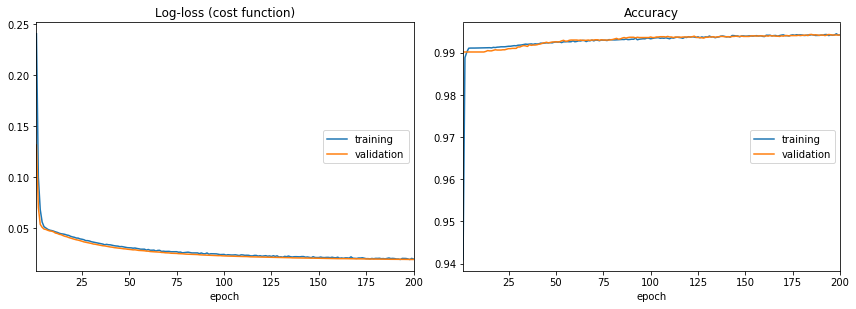

1311/1311 [==============================] - 3s 2ms/step - loss: 0.0195 - acc: 0.9943 - val_loss: 0.0190 - val_acc: 0.9942
Training duration (s) :  556.928680896759
345/345 [==============================] - 0s 319us/step
Test loss: 0.0214823273105
Test accuracy: 0.994229308591


In [22]:
global_start_time = time.time()
epochs  = 200

model = build_model([(2,vocab_size), len(encoder.classes_)])

model.summary()

plot_losses = livelossplot.PlotLossesKeras()

model.fit(x_train, y_train, batch_size=64, epochs=epochs, validation_split=0.05, callbacks=[plot_losses])

model.save('model_dense.h5')

model.save_weights('model_dense_weights.h5')

print('Training duration (s) : ', time.time() - global_start_time)

score = model.evaluate(x_test, y_test, 
                       batch_size=64)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

### Predictions

- test[0][0] for input options, separated by space
- test[0][1] for input answers, separated by space

- Prints:
    - All percentages of predicted categories
    - All Master KPs
    - Predicted Master KPs that are greater than the threshold = 0.5
    - Max prediction with corresponding percentage

In [38]:
threshold = 0.5

test = np.zeros((1,2,vocab_size))
test[0][0] = tokenize.texts_to_matrix(['he she we'])
test[0][1] = tokenize.texts_to_matrix(['we'])

prediction = model.predict(test)
print(prediction)

text_labels = encoder.classes_ 
print(text_labels)
predicted_label = []
for i, p in enumerate(prediction[0]):
    if p >= threshold:
        predicted_label.append(text_labels[i])
print("Predicted label: ")
print(predicted_label)
print(text_labels[np.argmax(prediction)])
print(np.amax(prediction[0]))

[[  1.25252306e-02   2.20653089e-03   2.05736374e-03   1.95572642e-03
    1.32492534e-03   5.40771580e-04   1.12913316e-03   2.82547080e-05
    5.47636359e-04   4.50450601e-03   1.46673631e-03   1.15485331e-02
    7.31191691e-03   1.78155431e-03   4.14296100e-03   4.39623557e-03
    5.89783303e-04   4.80561424e-03   4.56842332e-04   1.61790953e-03
    7.62775657e-04   1.08132011e-03   3.19592451e-04   1.21720042e-03
    1.42024597e-04   1.94852834e-03   4.62036356e-02   2.98872329e-02
    3.84565908e-03   3.49934236e-03   9.22821637e-05   4.18712065e-04
    3.77050659e-04   1.43760734e-03   3.18625243e-03   1.56744546e-03
    5.06010256e-05   1.03008107e-03   4.20954384e-05   4.04942315e-03
    1.25087276e-02   3.23929801e-03   2.65851654e-02   5.32633218e-04
    2.37154076e-04   1.01488607e-03   2.42816098e-03   2.24815129e-04
    2.09187460e-03   3.57930572e-03   2.52697471e-04   2.27864319e-03
    1.47501577e-03   1.63901527e-03   1.11089810e-03   4.37767478e-03
    6.90317759e-03  